### Install and/or load required packages

In [1]:
installOrLoadPackage <- function(listOfPackages) {
    repository <- 'https://cloud.r-project.org/'
    for (package in listOfPackages) {
        if (package %in% row.names(installed.packages()) == TRUE) {
            update.packages(package, dependecies = TRUE, repos=repository)
        } else {
            install.packages(package, repos=repository)
        }
        require(package, character.only = TRUE)
    }
}
installOrLoadPackage(c('openxlsx','mice','randomForest','pROC','treemap'))

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.3.3"Loading required package: mice
Warning message:
"package 'mice' was built under R version 3.3.3"Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: pROC
Warning message:
"package 'pROC' was built under R version 3.3.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: treemap
Warning message:
"package 'treemap' was built under R version 3.3.3"

### Load data and check if each sheet has only one client per row

In [2]:
fileLoc <- 'https://www.dropbox.com/s/87p72b5muuvisvu/Task_Data_Scientist_Dataset.xlsx?dl=1'
workBook <- loadWorkbook(file = fileLoc)
sheetList <- names(workBook)[-1]
for (i in sheetList) {
    cmd0 <- paste(tolower(i), ' <- read.xlsx(workBook, sheet = "', i, '")', sep='')
    cmd1 <- paste('table(',tolower(i),'$Client)','[table(',tolower(i),'$Client) > 1]',sep='')
    eval(parse(text=cmd0))
    print(i)
    print(eval(parse(text=cmd1)))
}

[1] "Soc_Dem"
named integer(0)
[1] "Products_ActBalance"
named integer(0)
[1] "Inflow_Outflow"
named integer(0)
[1] "Sales_Revenues"
named integer(0)


### Merge all sheets by client since each sheet has only one client per row

In [3]:
for (i in sheetList){
    if (i == sheetList[1]) cmd0 <- paste('raw <- ', tolower(i), sep='')
        else cmd0 <- paste('raw <- merge(raw, ', tolower(i), ', by="Client", all=TRUE)', sep='')
    eval(parse(text=cmd0))
}

### Tag each row as either 'train', 'test', 'new'
Tag 'new' if client was not found in sheet 'Sales_Revenues'. Randomly tag 85% of rows that are not 'new' as 'train'. Those remaining untagged, tag as 'train'. This is to separate the training and testing sets later.

In [4]:
raw$ident <- 'new'
set.seed(12345)
raw$ident[!is.na(raw$Sale_MF)] <- sample(c('train','test'),
                                         size=length(raw$Client[!is.na(raw$Sale_MF)]),
                                         replace=TRUE,
                                         prob=c(0.85,0.15))

### Correct data types

In [5]:
raw$Client <- as.character(raw$Client)

temp0 <- colnames(raw)[grepl(pattern='^ActBal',colnames(raw))]
for (i in temp0) raw[,i] <- as.numeric(raw[,i])

temp0 <- colnames(raw)[grepl(pattern='(^Sale)',colnames(raw))]
for (i in temp0) raw[,i] <- as.factor(raw[,i])

raw$Sex[is.na(raw$Sex)] <- 'X'
raw$Sex <- factor(raw$Sex, levels=c('X','F','M'))
temp0 <- data.frame(Sex=raw$Sex)
temp0 <- model.matrix(~Sex, temp0)[,-1]
colnames(temp0) <- c('Female','Male')
temp0 <- as.data.frame(temp0)
raw <- cbind(temp0,raw)
raw$Sex <- NULL

### Assumption on missing values
Assume clients that have no entries in count of active accounts to have no such accounts. Assume account balances to be zero for clients with no active accounts. Assume clients that have no entries in transactions to have no activity in the past three months.


In [6]:
temp0 <- colnames(raw)[grepl(pattern='(^ActBal)|(^Count)|(^Volume)|(^Transactions)',colnames(raw))]
for (i in temp0) raw[is.na(raw[,i]),i] <- 0

### Separate input variables, target variables, and other variables

In [7]:
inputVars <- colnames(raw)[!grepl(pattern='(^Client)|(^ident)|(^Sale)|(^Revenue)',colnames(raw))]
outputVars <- colnames(raw)[grepl(pattern='(^Sale)|(^Revenue)',colnames(raw))]
identVars <- colnames(raw)[!colnames(raw) %in% c(inputVars,outputVars)]

### Correct unlikely age of clients

In [8]:
raw$Age[quantile(raw$Age, na.rm=TRUE, probs=0.05) > raw$Age] <- NA
raw$Age[raw$Tenure/12 > raw$Age] <- NA
temp0 <- mice(raw[,c(inputVars,outputVars)], print=FALSE)
temp1 <- complete(temp0,1)
raw$Age <- temp1$Age
raw <- raw[,c(identVars,inputVars,outputVars)]

### Separate training, testing, and new sets

In [9]:
trainSet <- raw[raw$ident == 'train'   ,c('Client',inputVars,outputVars)] 
testSet  <- raw[raw$ident == 'test'    ,c('Client',inputVars,outputVars)] 
newSet   <- raw[raw$ident == 'new'     ,c('Client',inputVars)]

### Create formula for the different target variables

In [10]:
for (i in outputVars) {
    product <- gsub(pattern='(^Sale_)|(^Revenue_)', replace='', i)
    varList <- inputVars[!grepl(pattern=paste(product,'$',sep=''),inputVars)]
    cmd0 <- paste('eqn_', i, ' <- as.formula(',i, ' ~ ', paste(varList, collapse=' + '), ')',sep='')
    eval(parse(text=cmd0))
}

### Fit random forest models, and then print accuracy of models

In [11]:
set.seed(67890)
equations <- ls(all=TRUE)[grepl(pattern='^eqn', ls(all=TRUE))]
for (i in equations) {
    temp0 <- gsub(pattern='^eqn', replace='model', i)
    temp1 <- paste(temp0, ' <- randomForest(formula=', i, ', data=trainSet, keep.forest=TRUE)', sep='')
    temp2 <- paste('pred <- predict(',temp0,', newdata=testSet)', sep='')
    temp3 <- paste('actl <- testSet[,all.vars(', i, ')[1]]', sep='')
    eval(parse(text=temp1))
    eval(parse(text=temp2))
    eval(parse(text=temp3))
    if (grepl(pattern='Revenue',i)) {
        accuracy <- sqrt(mean((pred-actl)^2))
    } else {
        temp4 <- paste('pred <- predict(',temp0,', newdata=testSet, type="prob")[,"1"]', sep='')
        eval(parse(text=temp4))
        accuracy <- auc(roc(actl, pred))
    }
    print(temp0)
    print(accuracy)
}

[1] "model_Revenue_CC"
[1] 7.622769
[1] "model_Revenue_CL"
[1] 6.419038
[1] "model_Revenue_MF"
[1] 5.198948
[1] "model_Sale_CC"
Area under the curve: 0.5544
[1] "model_Sale_CL"
Area under the curve: 0.6586
[1] "model_Sale_MF"
Area under the curve: 0.5979


### Prediction of Client Response to Different Offers

In [12]:
models <- ls(all=TRUE)[grepl(pattern='^model_', ls(all=TRUE))]
for (i in models) {
    if (grepl(pattern='Revenue', i)) {
       temp0 <- paste('pred <- predict(', i,', newdata=newSet)', sep='')
    } else {
       temp0 <- paste('pred <- predict(', i,', newdata=newSet, type="prob")[,"1"]', sep='')
    }
    eval(parse(text=temp0))
    Client <- newSet$Client
    temp1 <- paste('temp2 <- data.frame(Client = Client, ',gsub(pattern='^model', replace='pred', i),' = pred)', sep='')
    eval(parse(text=temp1))
    if (i == models[1]) {
       predDF <- temp2
    } else {
       predDF <- merge(predDF, temp2, by='Client', all=TRUE)
    }
}


### Decision on which product to offer which clients based on the maximum expected revenue

In [13]:
predDF$expectedRevenue_CC <- predDF$pred_Revenue_CC * predDF$pred_Sale_CC
predDF$expectedRevenue_CL <- predDF$pred_Revenue_CL * predDF$pred_Sale_CL
predDF$expectedRevenue_MF <- predDF$pred_Revenue_MF * predDF$pred_Sale_MF
predDF$expectedRevenue <- apply(predDF[,colnames(predDF)[grepl(pattern='^expectedRevenue_', colnames(predDF))]], MARGIN=1, 
                                FUN=max)
predDF$recommendedOffer <- apply(predDF[,colnames(predDF)[grepl(pattern='^expectedRevenue_', colnames(predDF))]], MARGIN=1, 
                                 FUN=function(x) gsub(pattern='expectedRevenue_', replace='',names(which.max(x))))
predDF <- predDF[order(predDF$expectedRevenue, decreasing=TRUE),]
predDF$target <- 'No'
predDF$target[1:floor(dim(predDF)[1] * 0.15)] <- 'Yes'
head(predDF[predDF$target == 'Yes',],10)
print(sum(predDF$expectedRevenue[1:floor(dim(predDF)[1] * 0.15)]))
write.table(x=predDF, file='targetList.csv', sep=',', row.names=FALSE, col.names=TRUE)

,Client,pred_Revenue_CC,pred_Revenue_CL,pred_Revenue_MF,pred_Sale_CC,pred_Sale_CL,pred_Sale_MF,expectedRevenue_CC,expectedRevenue_CL,expectedRevenue_MF,expectedRevenue,recommendedOffer,target
579,84,58.937381,4.512209,6.177168,0.640,0.198,0.110,37.7199241,0.8934173,0.6794885,37.719924,CC,Yes
294,197,30.988225,10.650796,3.852269,0.726,0.258,0.174,22.4974512,2.7479053,0.6702948,22.497451,CC,Yes
544,766,2.994731,2.358784,40.106593,0.162,0.206,0.530,0.4851465,0.4859095,21.2564941,21.256494,MF,Yes
210,1460,57.855116,3.197672,2.197401,0.312,0.262,0.160,18.0507961,0.8377902,0.3515842,18.050796,CC,Yes
43,1093,2.960965,7.371222,30.880385,0.182,0.342,0.546,0.5388956,2.5209580,16.8606902,16.860690,MF,Yes
232,1508,2.317002,5.174187,45.092554,0.294,0.280,0.352,0.6811986,1.4487724,15.8725791,15.872579,MF,Yes
454,541,17.725850,6.059058,5.048196,0.642,0.268,0.152,11.3799960,1.6238276,0.7673257,11.379996,CC,Yes
165,1365,20.661755,6.110493,1.174461,0.538,0.498,0.324,11.1160241,3.0430256,0.3805253,11.116024,CC,Yes
303,217,3.362038,18.099264,18.354603,0.494,0.608,0.288,1.6608469,11.0043527,5.2861258,11.004353,CL,Yes
439,516,23.683660,3.691057,1.415315,0.404,0.308,0.238,9.5681988,1.1368455,0.3368451,9.568199,CC,Yes


[1] 633.7003


### Inspect Variable Imporantnce and Partial Dependence

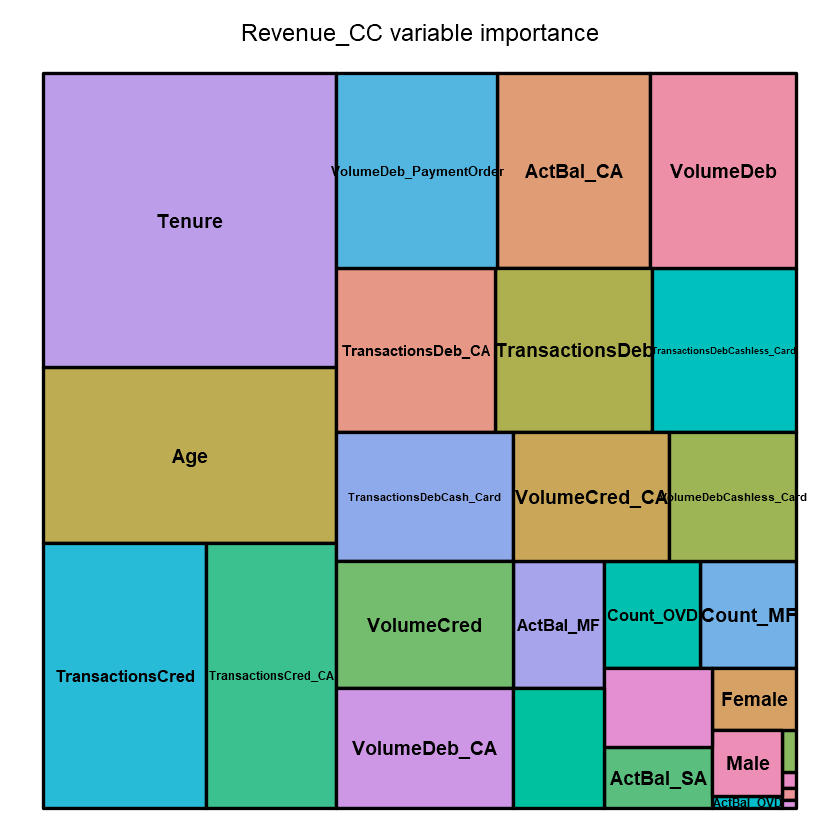

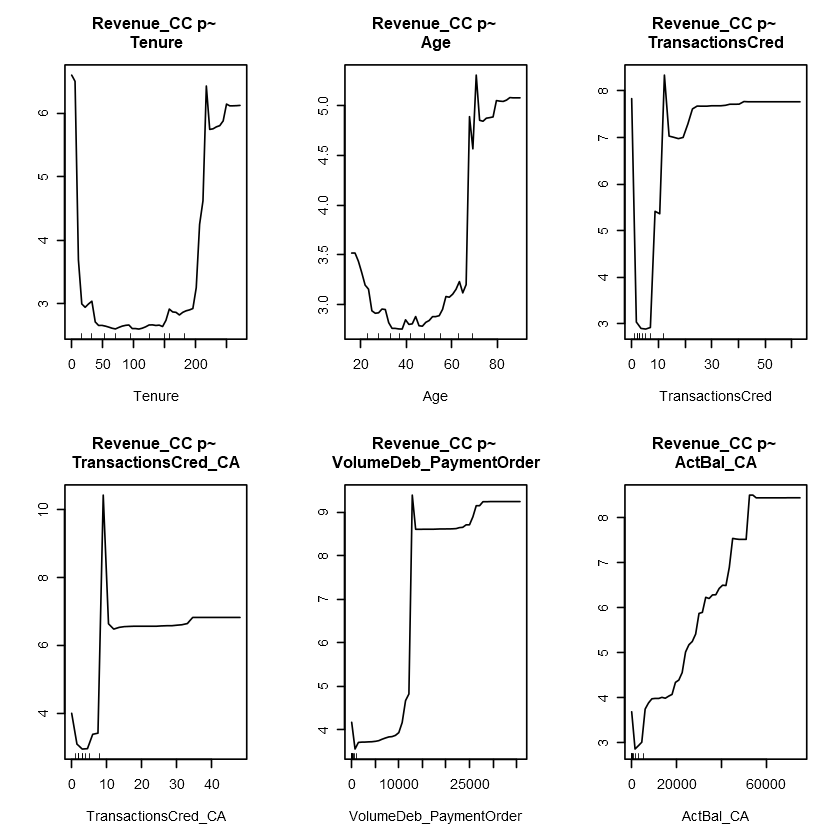

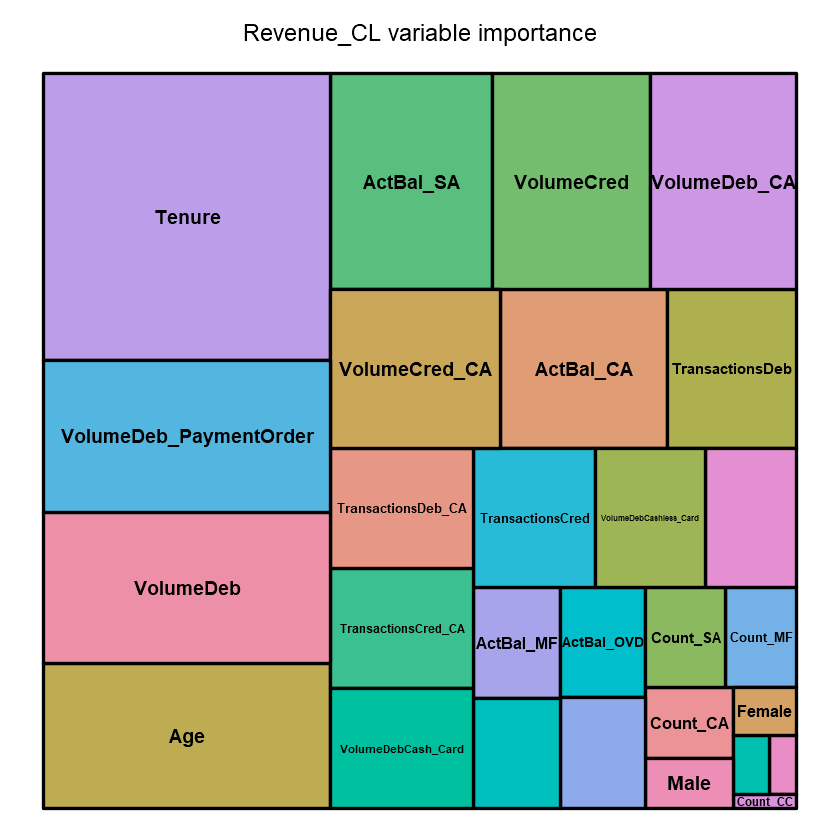

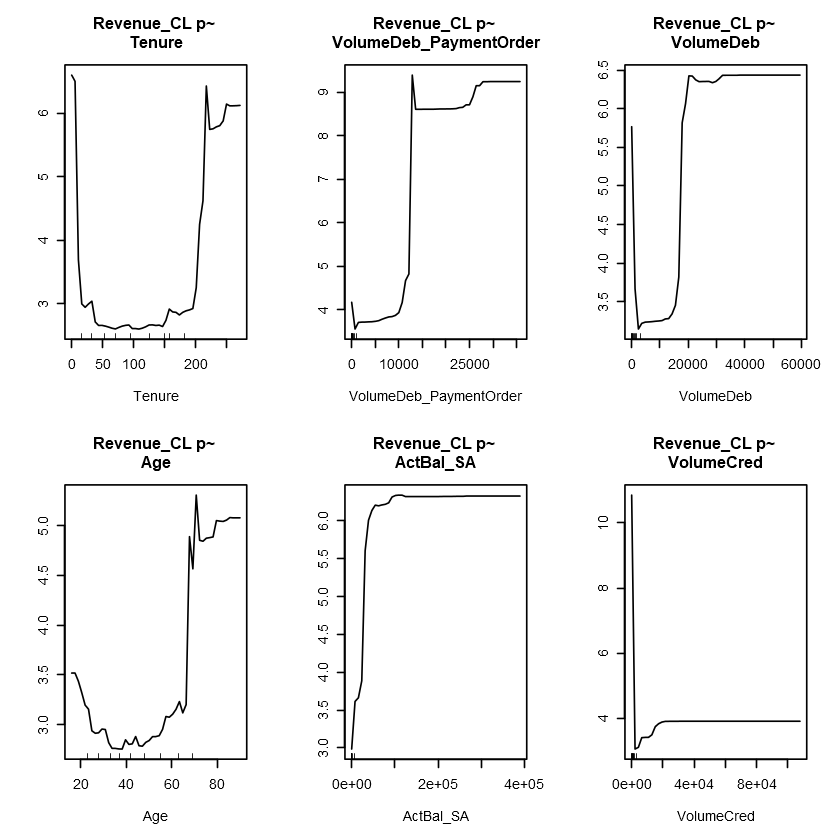

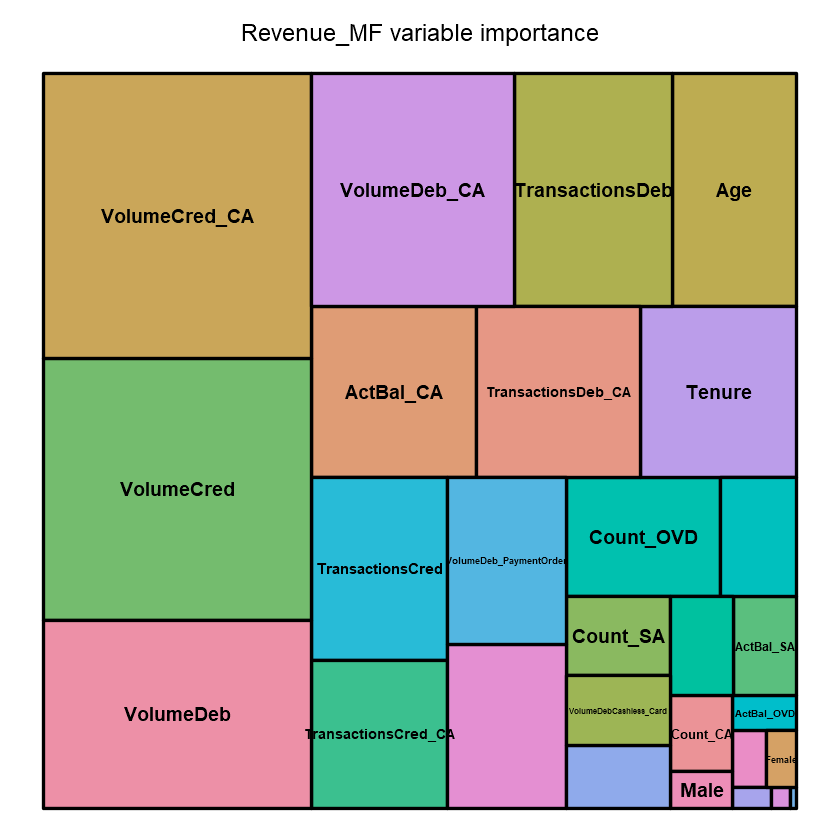

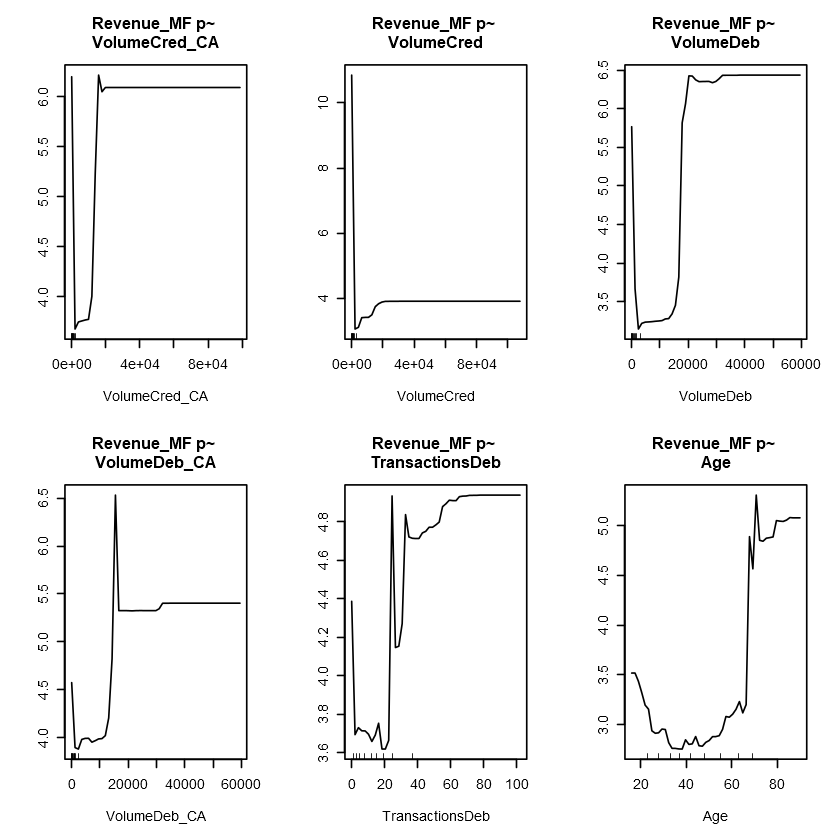

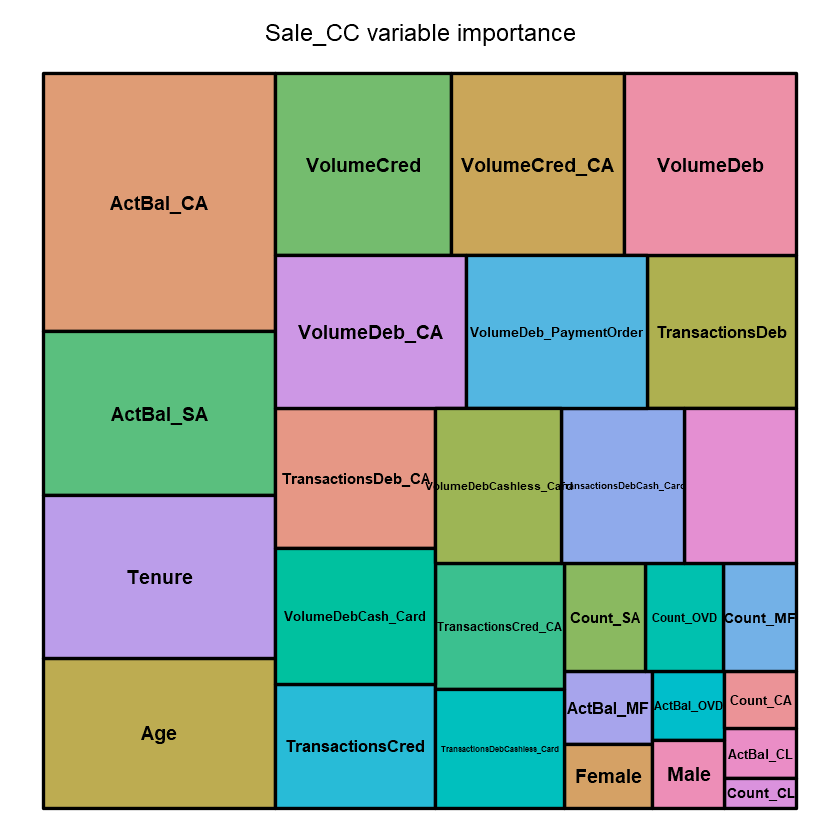

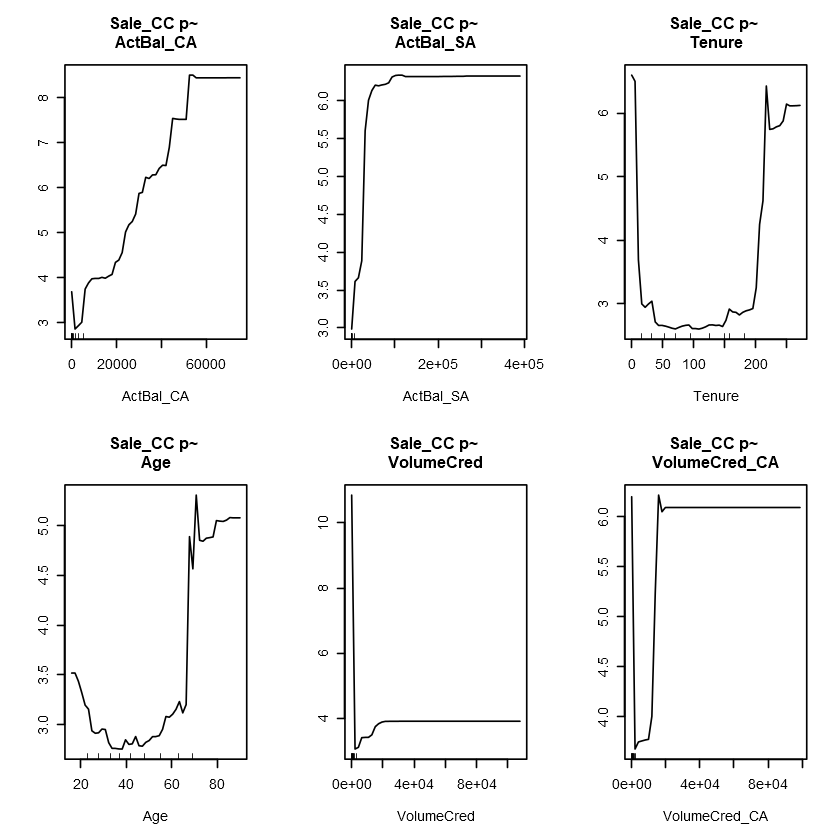

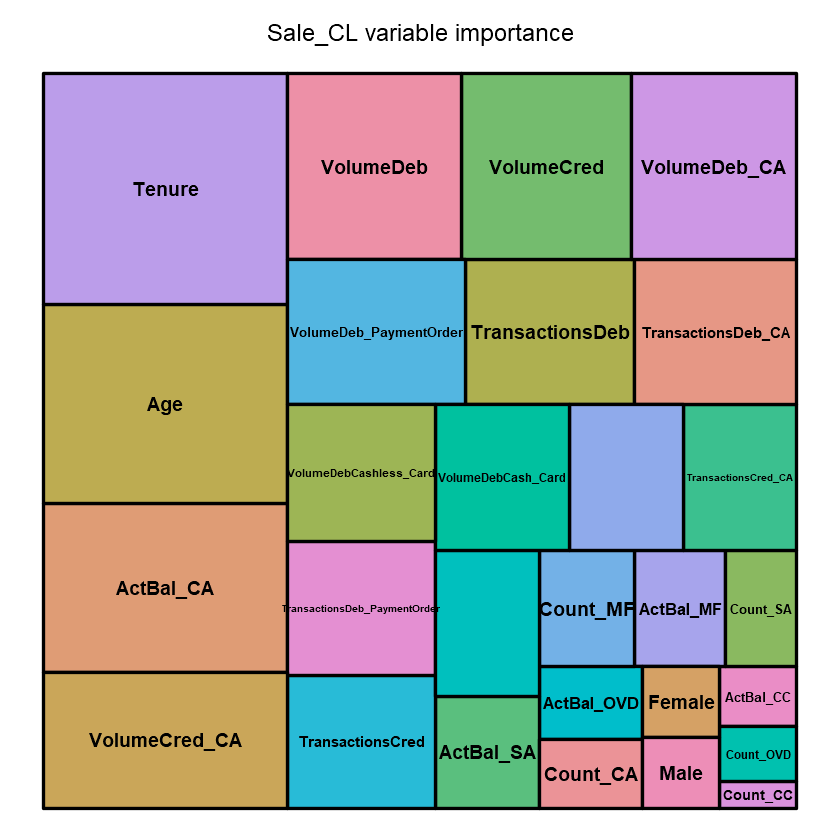

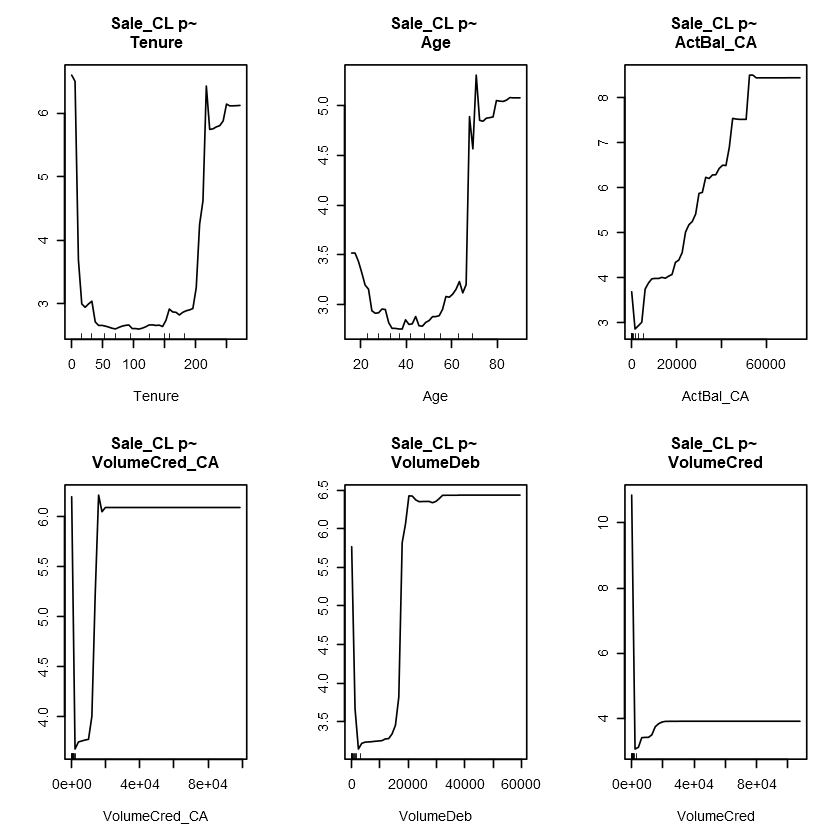

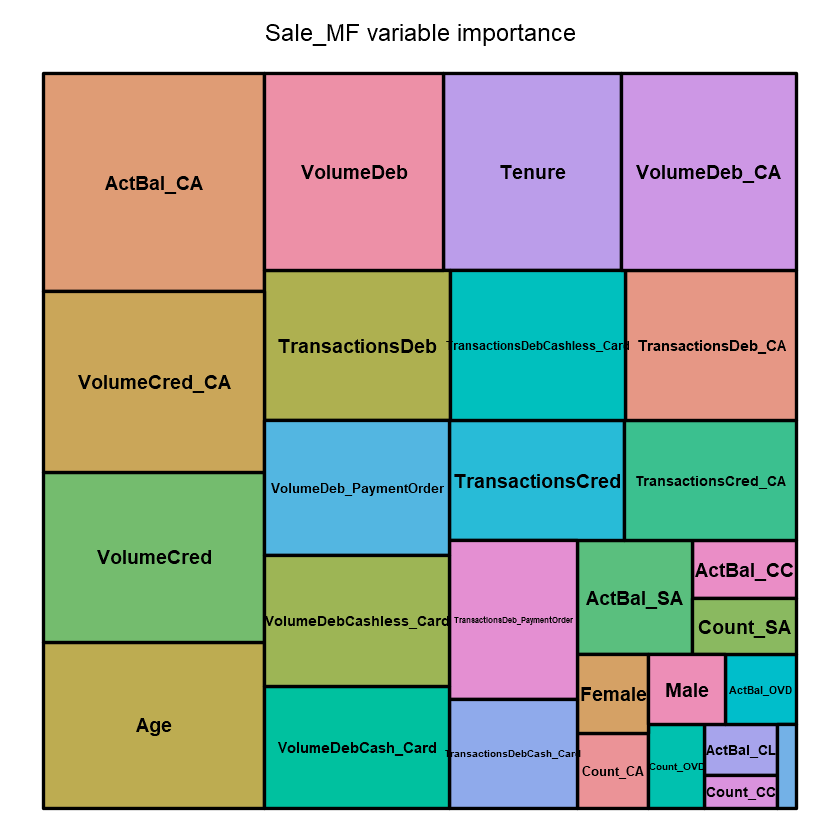

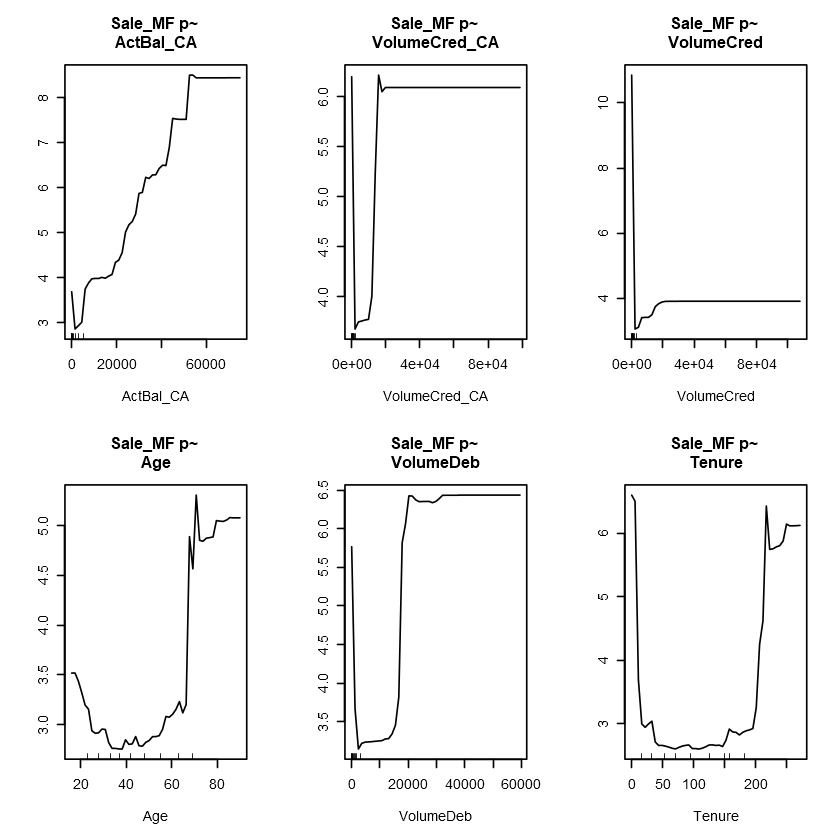

In [14]:
models <- ls(all=TRUE)[grepl(pattern='^model_', ls(all=TRUE))]
for (i in models) {
    temp0 <- paste('varImp <- importance(', i,')', sep='')
    eval(parse(text=temp0))
    temp1 <- rownames(varImp)[order(varImp, decreasing=TRUE)]
    temp2 <- data.frame(variable=rownames(varImp), importance=as.numeric(varImp))
    treemap(dtf=temp2, index='variable', vSize='importance', 
            title=paste(gsub(pattern='model_',replace='',i), ' variable importance', sep=''))
    op <- par(mfrow=c(2, 3))
    for (j in 1:6) {
         partialPlot(model_Revenue_CC, trainSet, temp1[j], xlab=temp1[j],
                main=paste(gsub(pattern='model_',replace='',i), ' p~ \n', temp1[j], sep=''))
    }
    par(op)
}